In [3]:
!pip install -r ../../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import polars as pl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np 
import polars_ols # needed for rolling OLS calculations using Polars
from skmisc.loess import loess
from matplotlib.gridspec import GridSpec
from mpl_bsic import apply_bsic_style, apply_bsic_logo, export_figure, add_title_subtitle, constants as bsic_constants

fonts already added so will not add again


# Loading Data

In [5]:
bond_data = pl.read_parquet('../../data/final_data/bond_data_oas.pq')
print(bond_data.head())

shape: (5, 99)
┌─────┬────────────┬───────────┬────────────┬───┬──────────┬─────────────┬──────────────┬──────────┐
│     ┆ date       ┆ cusip     ┆ exretn_t+1 ┆ … ┆ datadate ┆ shortintadj ┆ unexpected_i ┆ oas      │
│ --- ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---      ┆ ---         ┆ nflation     ┆ ---      │
│ i64 ┆ date       ┆ str       ┆ f64        ┆   ┆ date     ┆ f64         ┆ ---          ┆ f64      │
│     ┆            ┆           ┆            ┆   ┆          ┆             ┆ f64          ┆          │
╞═════╪════════════╪═══════════╪════════════╪═══╪══════════╪═════════════╪══════════════╪══════════╡
│ 7   ┆ 2002-08-31 ┆ 00077QAG5 ┆ 0.02983    ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.013937 │
│ 11  ┆ 2002-08-31 ┆ 00104CAA6 ┆ -0.023513  ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.184844 │
│ 12  ┆ 2002-08-31 ┆ 001055AB8 ┆ 0.004369   ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.016772 │
│ 20  ┆ 2002-08-31 ┆ 00130HAQ8 ┆ -0.080008  ┆ … ┆ null     ┆ null        ┆ 0

In [6]:
bond_data = bond_data.with_columns(
    spread_duration = pl.col('oas') / pl.col('bond_yield') * pl.col('duration')
)

## Quickly filtering out bonds close to default

**NB**: we are aware this introduces survivorship bias. A more thorough analysis of the strategy would require, among other things, considering the Credit Risk in the OAS calculation. Given the introductory nature of the article, we skip this part, which can be further developed in a subsequent article.

In [7]:
abnormal_prices = bond_data.filter(pl.col('bond_ret') >1).select('cusip').unique()
tot_cusips = bond_data.n_unique('cusip')

print(
    f'we have {len(abnormal_prices)} CUSIPs to remove, out of {tot_cusips} ({len(abnormal_prices) / tot_cusips * 100:.2f}%)'
)
# Segmenting in Buckets, based on Rating, Industry, Duration

we have 33 CUSIPs to remove, out of 11324 (0.29%)


In [8]:
abnormal_prices = bond_data.filter(pl.col('bondprc') < 75).select('cusip').unique()
tot_cusips = bond_data.n_unique('cusip')

print(f'we have {len(abnormal_prices)} CUSIPs to remove, out of {tot_cusips} ({len(abnormal_prices) / tot_cusips * 100:.2f}%)')
bond_data = bond_data.filter(~pl.col('cusip').is_in(abnormal_prices))

we have 1809 CUSIPs to remove, out of 11324 (15.97%)


# Segmenting in Buckets, based on Rating, Industry, Duration

Refer to the article for the rationale used for dividing the bonds into buckets. The main guiding principle behind this section of the analysis was finding a sweet spot between having similar groups and having enough bonds per group to make the return quantiles statistically significant and "stable".

## Rating

Group by rating macro-categories 

In [9]:
bond_data_with_ratings = bond_data.with_columns(
    rating_bucket=pl
        .when(pl.col('rating') <= 7).then(pl.lit('A'))
        .when(pl.col('rating') <= 16).then(pl.lit('B'))
        .otherwise(pl.lit('B'))
)
bond_data = bond_data_with_ratings

## Industry

We choose the following macro-groups, based on the first digit of the SIC Code: 

- 0, 1: Agriculture, Forestry, Fishing (0) + Mining (1) + Construction (1)
- 2, 3, 5: Manufacturing (2,3), Whole Sale Trade + Retail Trade (5)
- 4, 7, 8, 9: Transportation and Public Utilities (4), Public Administration (9), Service (7, 8)
- 6: Finance, Insurance, Real Estate (6)


In [10]:
bond_data.select('PERMNO', 'sic_code').head(4)

PERMNO,sic_code
i64,i64
84766,6029
57904,6321
66413,7830
77481,4922


In [11]:
bond_data = bond_data.with_columns(
    industry_bucket=pl.col('sic_code').cast(str).str.slice(0,1).cast(int)
).with_columns(
    # assign bucket from 1 to 5 for the corresponding macro-group
    industry_bucket=pl
        .when(pl.col('industry_bucket').is_in([0,1])).then(pl.lit(1))
        .when(pl.col('industry_bucket').is_in([2,3,5])).then(pl.lit(2))
        .when(pl.col('industry_bucket').is_in([4,9])).then(pl.lit(3))
        .when(pl.col('industry_bucket') == 6).then(pl.lit(4))
        .when(pl.col('industry_bucket').is_in([7,8])).then(pl.lit(5))
)

bond_data.select('industry_bucket').head(3)

industry_bucket
i32
4
4
5


In [12]:
bond_data.select('industry_bucket').unique()

industry_bucket
i32
3
1
4
5
2


## Duration 

In [13]:
bond_data.select('duration').quantile(0.5)

duration
f64
5.385079


In [14]:
bond_data = bond_data.with_columns(
    duration_bucket=pl
        .when(pl.col('duration') <= 5.5).then(pl.lit('shortdur'))
        .otherwise(pl.lit('longdur'))
)


## Aggregate the buckets in one column

In [15]:
bond_data = bond_data.with_columns(
    bucket=(pl.col('industry_bucket').cast(str) + '_' + pl.col('rating_bucket') + '_' + pl.col('duration_bucket').cast(str))
).drop(['industry_bucket', 'rating_bucket', 'duration_bucket'])

In [16]:
bond_data.select('bucket').head(3)

bucket
str
"""4_A_shortdur"""
"""4_A_shortdur"""
"""5_B_longdur"""


In [17]:
bonds_per_date_bucket = bond_data.group_by(['date', 'bucket']).n_unique().select('date', 'bucket', 'cusip')

bonds_per_date_bucket.head()

date,bucket,cusip
date,str,u32
2007-07-31,"""5_B_longdur""",37
2011-06-30,"""5_A_longdur""",21
2021-03-31,"""5_A_shortdur""",33
2003-11-30,"""5_A_shortdur""",11
2018-07-31,"""2_A_shortdur""",340


In [19]:
# how many buckets have less than 10 bonds?
bonds_per_date_bucket.filter(pl.col('cusip') < 10).shape[0] / bonds_per_date_bucket.shape[0]

0.06854421205218472

# Compute Residual Returns

Since there are outliers in buckets, which will have a strong impact (especially when the number of bonds is low), we opt to use the weighted median as opposed to the weighted mean, which is used in the original paper. 

In [22]:
def weighted_median_pl(data: pl.type_aliases.Sequence[pl.Series]):
    """Compute weighted median of observations with Polars

    To be used inside map_groups, to which you specify as expressions first the values, then the weights to use.
    The function takes two pl.Series: the first is the values to use, the second is the weights. 
    The function returns the weighted median for the given group of observations
    """
    values, weights = data
    values = values.to_numpy()
    weights = weights.to_numpy()
    i = np.argsort(values) 
    c = np.cumsum(weights[i])

    weighted_median = values[i[np.searchsorted(c, 0.5 * c[-1])]]
    return weighted_median


In [23]:
def compute_residual_returns(df: pl.DataFrame, oas_column: str = 'oas', use_median: bool = False):
    """Compute Residual return as unadjusted return - systematic return.
    
    * dxs = Duration * Spread
    * Systematic Return = Relative DTS * Weighted average return of bond's bucket
    * Relative dxs = Bond DTS / weighted average DTS of bond bucket
    
    * Residual return = bond_ret_t+1 - Systematic Return
    
    """
    df = df.with_columns(
        dxs = pl.col('spread_duration') * pl.col(oas_column)
    )
    
    grouped = df.select('bucket', 'dxs', 'exretnc_dur_t+1', 'bond_amount_out').drop_nulls().group_by('bucket')
    
    if use_median: 
        weighted_dxs = grouped.agg(
            weighted_dxs_median=pl.map_groups(exprs=['dxs', 'bond_amount_out'], function=weighted_median_pl),
            weighted_ret_median=pl.map_groups(exprs=['exretnc_dur_t+1', 'bond_amount_out'], function=weighted_median_pl)
        )
    else: 
        weighted_dxs = grouped.agg(
            weighted_dxs_mean=(pl.col('dxs').dot(pl.col('bond_amount_out')) / pl.sum('bond_amount_out')),
            weighted_ret_mean=(pl.col('exretnc_dur_t+1').dot(pl.col('bond_amount_out')) / pl.sum('bond_amount_out')),
        )
        
    dxs_col = 'weighted_dxs_' + ('median' if use_median else 'mean')
    ret_col = 'weighted_ret_' + ('median' if use_median else 'mean')
    
    df = (df.select(pl.all().exclude(dxs_col, ret_col))
        .join(weighted_dxs, how='left', on='bucket')
        .with_columns(
            relative_dxs = pl.col('dxs') / pl.col(dxs_col)
        ).with_columns(
            systematic_return = pl.col('relative_dxs') * pl.col(ret_col)
        ).with_columns(
            (pl.col('bond_ret_t+1') - pl.col('systematic_return')).alias('residual_return_t+1'),
        ))
    
    return df

In [24]:
bond_data = compute_residual_returns(bond_data, use_median=True, oas_column='oas')

In [26]:
bond_data.select('residual_return_t+1').describe()

statistic,residual_return_t+1
str,f64
"""count""",650533.0
"""null_count""",126331.0
"""mean""",0.001271
"""std""",0.023328
"""min""",-0.876593
"""25%""",-0.006616
"""50%""",0.001388
"""75%""",0.010137
"""max""",0.449917


# Signal Evaluation 

We first create a signal class, which will store the functions needed to analyze the signals and to plot the graphs included in the article.

## Signal Class

In [31]:
class Signal(): 
    def __init__(self, df: pl.DataFrame, column: str, n_quantiles: int, signal_value_name: str):
        self.df = df
        self.column = column
        self.n_quantiles = n_quantiles
        
        self.quantile_col_name = f'{column}_quantile'
        self.delta_col_name = f'{column}_delta'
        self.mean_col_name = f'{column}_bucket_mean'
        self.signal_value_name = signal_value_name
        self.return_col = 'residual_return_t+1'
        
        self.transition_probabilities = None
        self.spline = None
        self.alpha_estimates = None
        
    def compute_quantiles(self):
        """Divide the cols in quantiles based on the bucket groups"""
        
        quantile_col_name, delta_col_name, mean_col_name = self.quantile_col_name, self.delta_col_name, self.mean_col_name
        col = self.column
        n_quantiles = self.n_quantiles
        df = self.df
        
        # create the bins and labels to be used in qcut
        bins = np.linspace(0,1,n_quantiles+1)[1:]
        labels = [str(i+1) for i in range(n_quantiles+1)]
        
        # compute the mean of the signal for each bucket at each date
        col_mean_by_bucket = df.select('date', 'bucket', col).group_by(['date', 'bucket']).agg(
            pl.col(col).drop_nans().mean().alias(mean_col_name) # .mean breaks with NaNs, so drop them 
        )
        
        # join the dataframes and compute the difference with respect to the group average (computed before)
        deltas = (df
                  .select(pl.all().exclude(quantile_col_name, mean_col_name))
                  .join(col_mean_by_bucket, how='left', on=['date', 'bucket'])
                  .with_columns(
                        (pl.col(col) - pl.col(mean_col_name)).alias(delta_col_name)
                    )           
                  )
        # just select the cols we need, to make computations faster
        deltas = deltas.select('date', 'cusip', 'bucket', delta_col_name)
    
        data = []
        total_items = col_mean_by_bucket.shape[0]
        print('computing... ', end='')
    
        i = 0
        for group in col_mean_by_bucket.iter_rows(named=True):
            i += 1
            
            # filter for NaNs and Nulls as well 
            mask = (pl.col('date') == group['date']) & (pl.col('bucket') == group['bucket']) & (pl.col(delta_col_name).is_not_nan() & (pl.col(delta_col_name).is_not_null()))
            
            group_data = deltas.filter(mask)
            # if the DataFrame is emtpy just continue, otherwise qcut will throw an error
            if group_data.shape[0] == 0:
                continue
            
            group_data = group_data.with_columns(
                pl.col(delta_col_name).qcut(bins,labels=labels, allow_duplicates=True).alias(quantile_col_name)
            )
                
            data.append(group_data)
            
            if i % 1000 == 0: 
                print(f'{i}/{total_items} ', end='')
        
        print('... done!')
        
        quantiles = pl.concat(data, how='vertical')
        quantiles = quantiles.with_columns(
            pl.col(quantile_col_name).cast(int).alias(quantile_col_name)
        )
        
        merged_df = df.join(quantiles.drop('bucket'), how='left', on=['date', 'cusip'])
        
        self.df = merged_df
        return merged_df
    
    def information_ratio(self): 
        quantile_col, return_col = self.quantile_col_name, self.return_col
        if not quantile_col in self.df.columns: 
            self.compute_quantiles()
        
        df = self.df 
        
        # group returns by date and the quantile, and compute the average return of the portfolio at the end of every month
        signal_monthly_returns = df.group_by(['date', quantile_col]).agg(
            pl.col(return_col).drop_nans().mean().alias('mean_return'), # mean return of the portfolio at EoM
        ).filter(pl.col(quantile_col).is_not_null())
        
        signal_monthly_returns = signal_monthly_returns.sort(['date', quantile_col])
        
        long_short_returns = signal_monthly_returns.pivot(index='date', columns=quantile_col, values='mean_return').with_columns(
            (pl.col('10')-pl.col('1')).alias('long_short')
        ).select('date', 'long_short')
        market_returns = df.group_by('date').agg(pl.col(return_col).mean().alias('mkt_return'))
        
        portfolio_returns = long_short_returns.join(market_returns, how='left', on='date').with_columns(
            delta=(pl.col('long_short')-pl.col('mkt_return'))
        )
        
        information_ratio = portfolio_returns['delta'].mean() / portfolio_returns['delta'].std()
        
        return information_ratio * np.sqrt(12)

    def compute_expected_alpha(self): 
        quantile_col, return_col = self.quantile_col_name, self.return_col
        if not quantile_col in self.df.columns: 
            self.compute_quantiles()
        
        df = self.df 
        
        
        # group returns by date and the quantile, and compute the average return of the portfolio at the end of every month
        monthly_returns_by_bucket = df.group_by(['date', quantile_col]).agg(
            pl.col(return_col).drop_nans().mean().alias('mean_return'), # mean return of the portfolio at EoM
        )
        
        final_portfolio_returns = monthly_returns_by_bucket.group_by(quantile_col).agg(
            pl.col('mean_return').mean().alias('avg_monthly_return'),
            pl.col('mean_return').std().alias('monthly_stdev'),
            ((pl.col('mean_return').mean() / pl.col('mean_return').std()) * np.sqrt(12)).alias('sharpe_ratio'),
        )
        
        # insert the key to sort by        
        alpha_estimates = final_portfolio_returns.sort(by=quantile_col).drop_nulls().select(quantile_col, 'avg_monthly_return', 'monthly_stdev')
        
        data = alpha_estimates.select(quantile_col, 'avg_monthly_return').to_numpy()
        x, y = data[:, 0], data[:, 1]
        
        spline = loess(x, y, surface='direct')
        spline.fit()
        
        self.spline = spline    
        self.alpha_estimates = alpha_estimates

        return alpha_estimates, spline

    def fit_alpha_estimates(self):
        df, spline = self.df, self.spline
        quantile_col = self.quantile_col_name
        signal_value_name = self.signal_value_name
        
        if quantile_col not in df.columns:
            df = self.compute_quantiles()
            
        if spline is None: 
            self.compute_expected_alpha()
            spline = self.spline
        
        
        def f(x: pl.Series): 
            data = x.to_numpy()
            n = len(data)
            
            values = np.zeros(n)
            values[:] = np.nan
            
            for i in range(n):
                val = data[i]
                if np.isnan(val):
                    continue
                signal_val = spline.predict([val]).values
                values[i] = signal_val[0]
                
            return values
        
        df = df.with_columns(
            pl.col(quantile_col).map_batches(function=f, return_dtype=pl.Float64).fill_nan(None).alias(signal_value_name),
        ).with_columns(
            ((pl.col(signal_value_name) - pl.col(signal_value_name).drop_nulls().mean()) / pl.col(signal_value_name).drop_nulls().std()).alias(signal_value_name)
        )
        
        self.df = df 
        return df 
    
    
    def compute_transition_matrix(self, lag: int = 1):
        """Compute the transition probabilities for quantiles for a given signal, given a certain lag (1 unit of lag is 1 month of time)"""
        def _update_transition_prob_matrix(chain, counts_matrix, lag):
            flat_coords = np.ravel_multi_index((chain[:-lag], chain[lag:]), counts_matrix.shape)
            return np.bincount(flat_coords, minlength=counts_matrix.size).reshape(counts_matrix.shape)
    
        def _convert_to_probabilities(transition_matrix: np.ndarray): 
            M = transition_matrix.copy()
            for row in M: 
                n = sum(row)
                if n > 0: 
                    row[:] = [f/n for f in row] 
            
            return M
        
        quantile_col, n_quantiles = self.quantile_col_name, self.n_quantiles
        if not quantile_col in self.df.columns: 
            self.compute_quantiles()
            
        df = self.df
        # group by the cusip, and get the evolution of the quantile during time for each bond
        quantiles_evolution = df.sort('date').filter(pl.col(quantile_col).is_not_null()).group_by('cusip', maintain_order=True).agg(pl.col(quantile_col))
        
        # initialize the matrix of transition probabilities
        transition_probabilities = np.zeros((n_quantiles, n_quantiles), dtype=np.float64)
        
        # iterate through the different evolutions and update the transition probabilities
        for row in quantiles_evolution.iter_rows(): 
            chain = row[1]
            if np.min(chain) != 0: 
                chain -= np.min(chain)
            
            transition_probabilities[:, :] += _update_transition_prob_matrix(chain, transition_probabilities, lag)
        
        # convert these to actual probabilities
        transition_probabilities = _convert_to_probabilities(transition_probabilities)
        self.transition_probabilities = transition_probabilities
        
        return transition_probabilities
        
    def plot(self, title: str, probabilities_lag: int = 1):
        plt.style.use('default')
        quantile_col = self.quantile_col_name 
        n_quantiles = self.n_quantiles
        
        if self.transition_probabilities is None: 
            self.compute_transition_matrix(probabilities_lag)
        if self.spline is None: 
            self.compute_expected_alpha()
        
        transition_probs = self.transition_probabilities
        alpha_estimates, spline = self.alpha_estimates, self.spline
        
        fig = plt.figure(figsize=(10,8))
        gs = GridSpec(2,2, figure=fig, bottom=0.1, top=0.9, width_ratios=(3, 2), hspace=0.3) 
        
        barchart_ax = fig.add_subplot(gs[0,0])
        probs_ax = fig.add_subplot(gs[0,1])
        spline_ax = fig.add_subplot(gs[1,:])
        apply_bsic_style(fig, sources=['WRDS', 'openbondassetpricing'])
        
        bsic_cmap = mcolors.LinearSegmentedColormap.from_list(
            "bsic", ["#8EC6FF", "#38329A", "#0E0B54", "#601E66"]
        )
        
        # plot the barchart
        barchart_ax.bar(x=alpha_estimates[quantile_col], height=alpha_estimates['avg_monthly_return'] * 1e2, alpha=0.75)
        volatilities_ax = barchart_ax.twinx()
        volatilities_ax.set_ylabel('Monthly Volatility (bps)')
        volatilities_ax.plot(alpha_estimates[quantile_col], alpha_estimates['monthly_stdev'] * 1e4, label='Volatility', color=bsic_constants.BSIC_COLORS[2], linestyle=(0,(5,10)), marker='o')
        volatilities_ax.legend()
        
        barchart_ax.set_title('Average Monthly Return by Quantile', **bsic_constants.TITLE_STYLE)
        barchart_ax.set_xlabel('Quantile')
        barchart_ax.set_ylabel('Expected Monthly Alpha (%)')
        
        # plot the transition probability matrix
        probs_ax.imshow(transition_probs, cmap=bsic_cmap, interpolation='nearest')
        probs_ax.set_axis_off()
        probs_ax.set_title(f'Transition Probabilities ({probabilities_lag}Mo, %)', **bsic_constants.TITLE_STYLE)
        for (j,i), label in np.ndenumerate(transition_probs):
            probs_ax.text(i,j,int(label * 100),ha='center',va='center', color='white', fontweight='bold', fontsize=10)
        
        # plot the spline in the bottom
        spline_ax.axhline(y=0, c='black', lw=1)
        
        x_new = np.linspace(0,n_quantiles, 100)
        pred = spline.predict(x_new, stderror=True)
        conf = pred.confidence()
        
        lowess_vals = pred.values
        ll = conf.lower
        ul = conf.upper
        
        
        spline_ax.fill_between(x_new,ll,ul,alpha=0.3)
        spline_ax.scatter(x=alpha_estimates[quantile_col], y=alpha_estimates['avg_monthly_return'], label='Expected Alpha', color=bsic_constants.BSIC_COLORS[2])
        spline_ax.plot(x_new, lowess_vals)
        
        spline_ax.set_title('Fitted LOWESS Estimator, with 95% CI', **bsic_constants.TITLE_STYLE)
        spline_ax.set_xlabel('Quantile')
        spline_ax.set_ylabel('Expected Monthly Alpha')
        
        suptitle_style = bsic_constants.TITLE_STYLE.copy() 
        suptitle_style['fontsize'] = 16
        fig.suptitle(title, **suptitle_style)
        
        # apply_bsic_style(fig, spline_ax)
        # apply_bsic_style(fig, spline_ax)
        
        
        subtitle = "Expected Alpha and Volatility of Carry Factor, Transition Probabilities and fitted LOWESS curve."
        # add_title_subtitle(fig, title, subtitle)
        return fig
        

## Carry

For carry, we rank each bond based on its OAS. 

In [32]:
carry_signal = Signal(bond_data, 'oas', 10, 'carry_signal_value')
carry_signal.compute_quantiles()
ir_carry = carry_signal.information_ratio()

print(f'IR for Carry Signal: {ir_carry}')


computing... 1000/4829 2000/4829 3000/4829 4000/4829 ... done!
IR for Carry Signal: 0.7772769713330139


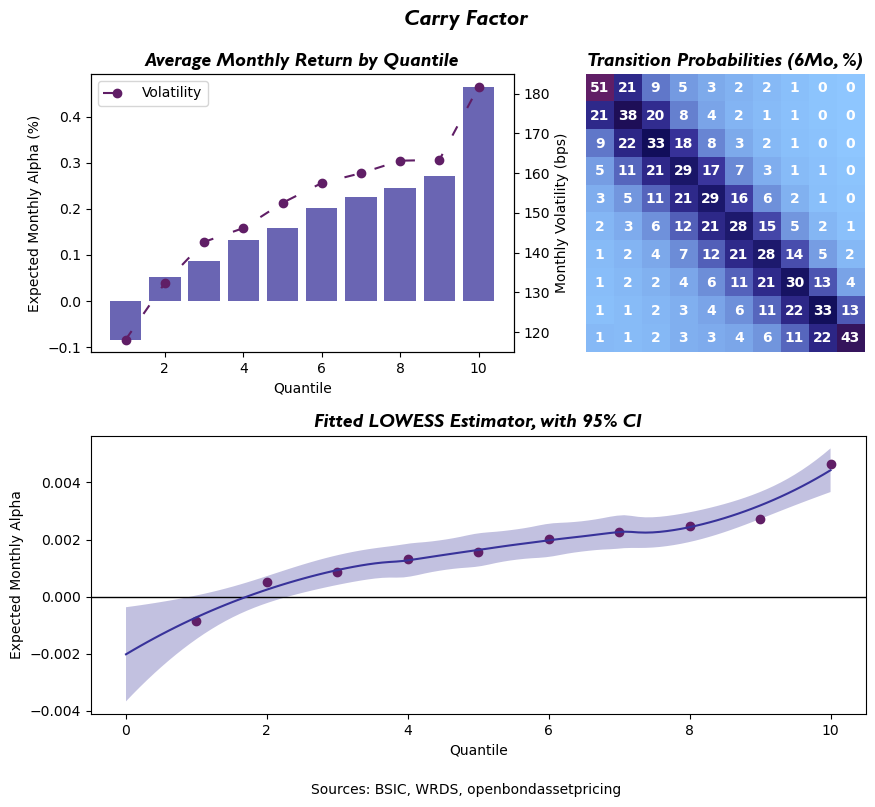

In [33]:
fig = carry_signal.plot(title='Carry Factor', probabilities_lag=6)

In [35]:
# graph used for the instagram post
def plot_instagram():
    alpha_estimates, _ = carry_signal.compute_expected_alpha()
    quantile_col = 'oas_quantile'
    
    fig, barchart_ax = plt.subplots()
    apply_bsic_style(fig)
    barchart_ax.bar(x=alpha_estimates[quantile_col], height=alpha_estimates['avg_monthly_return'] * 1e2, alpha=0.75)
    volatilities_ax = barchart_ax.twinx()
    volatilities_ax.set_ylabel('Monthly Volatility (bps)')
    volatilities_ax.plot(alpha_estimates[quantile_col], alpha_estimates['monthly_stdev'] * 1e4, label='Volatility', color=bsic_constants.BSIC_COLORS[2], linestyle=(0,(5,10)), marker='o')
    volatilities_ax.legend()
    
    barchart_ax.set_title('Average Monthly Return by Quantile', **bsic_constants.TITLE_STYLE)
    barchart_ax.set_xlabel('Quantile')
    barchart_ax.set_ylabel('Expected Monthly Alpha (%)')
    title = 'test'
    subt = 'test subt'
    add_title_subtitle(fig, title, subt, subtitle_bottom_margin=-220, title_bottom_margin=-200)
    
    export_figure(fig, '../../exports/carry_factor.svg')

# plot_instagram()

In [36]:
carry_signal.fit_alpha_estimates()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,COUPACC,MULTICOUPS,RET_EOM,RET_LDM,RET_L5M,REMCOUPS,DURATION_right,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,i64,str,str,str,i64,f64,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64
7,2002-08-31,"""00077QAG5""",0.02983,0.002463,0.007751,0.03123,0.00401,0.00261,-0.008908,4.0,0.016845,null,0.045433,750000.0,750000.0,111.0,1.11,58.4,4.043507,16.0,6029,0.057967,5.167562,null,19.0,1.0,1.0,0.043869,0.014981,111.7082,113.192577,19.936427,null,8.325e7,8.378115e7,7.125,…,1.44,1,""".4010%""",""".4010%""",""".4010%""",10,4.04,null,null,null,null,84766,31989,2002-07-01,2007-06-13,null,null,null,null,null,null,0.176487,null,null,0.004985,0.013937,1.240343,"""4_A_shortdur""",0.017286,0.008112,0.000932,2.130888,0.001986,0.029244,-0.00185,5,-0.091239
12,2002-08-31,"""001055AB8""",0.004369,-0.029192,-0.024985,0.005769,0.019975,0.018575,0.002447,6.0,0.019995,0.108357,0.052927,450000.0,450000.0,106.654741,1.066547,80.633333,5.26686,16.0,6321,-0.00998,3.822493,0.01842,6.0,1.0,1.0,0.058477,0.024118,103.533,105.952447,33.928569,null,4.7994634e7,4.658985e7,6.5,…,2.46,1,"""1.997%""",null,"""1.997%""",14,5.27,null,null,null,null,57904,92,2002-07-02,2009-04-06,1449,0.177,1.062,6.11,65.722,null,-0.023535,null,null,0.004985,0.016772,1.668995,"""4_A_shortdur""",0.027992,0.008112,0.000932,3.450626,0.003215,0.002554,0.000985,7,0.356791
29,2002-08-31,"""001669AK6""",-0.04318,-0.083093,-0.073021,-0.04178,-0.011484,-0.012884,-0.029708,17.0,0.074819,0.20692,0.108415,225000.0,225000.0,92.65625,0.9265625,102.533333,5.531382,17.0,7830,-0.019237,0.140351,0.2544,9.0,1.0,1.0,0.110487,0.07599,91.6335,92.398779,40.603425,null,2.0847656e7,2.0617538e7,9.5,…,0.78,1,"""-1.148%""",null,"""-1.148%""",17,5.53,null,null,null,null,66413,6301,2002-07-01,2004-12-23,1038,0.731,3.811,4.392,0.925,0.517,-0.092828,null,null,0.004985,0.070275,3.585443,"""5_B_longdur""",0.251966,0.088843,0.002781,2.836081,0.007888,-0.049667,0.028921,10,1.90209
41,2002-08-31,"""001814AR3""",null,null,null,null,null,null,null,8.0,0.057331,0.599358,0.096175,300000.0,300000.0,null,null,233.4,8.416409,14.0,4922,null,null,null,null,1.0,1.0,null,null,null,null,null,null,null,null,9.625,…,3.22,1,"""-8.065%""",null,null,39,8.42,null,null,null,null,77481,22983,2002-07-22,2012-05-24,4242,0.622,4.737,3.898,2.057,0.115,0.170244,null,null,0.004985,NaN,NaN,"""3_B_longdur""",NaN,0.081706,0.002549,NaN,NaN,null,null,null,null
43,2002-08-31,"""00184AAB1""",-0.046941,-0.087589,-0.078428,-0.045541,0.106344,0.104944,0.086622,8.0,0.050563,0.984818,0.085586,1e6,1e6,89.10387,0.891039,104.966667,6.100444,17.0,7375,0.080269,2.161968,null,21.0,1.0,1.0,0.08402,0.048508,90.0,92.5875,48.388638,null,8.910387e7,9e7,6.75,…,2.55,1,"""10.63%""","""10.63%""","""10.63%""",18,6.1,null,null,null,null,77418,11412,2002-07-01,2003-10-15,25056,0.166,5.64,0.437,1.888,0.094,0.099999,null,null,0.004985,0.046339,3.302929,"""5_B_longdur""",0.153053,0.088843,0.002781,1.722736,0.004791,-0.050332,0.004985,8,0.479109
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1

In [37]:
# we overwrite the bond_data dataframe with the one that contains the signal quantiles and value for carry
bond_data = carry_signal.df

bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,COUPACC,MULTICOUPS,RET_EOM,RET_LDM,RET_L5M,REMCOUPS,DURATION_right,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,i64,str,str,str,i64,f64,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64
7,2002-08-31,"""00077QAG5""",0.02983,0.002463,0.007751,0.03123,0.00401,0.00261,-0.008908,4.0,0.016845,null,0.045433,750000.0,750000.0,111.0,1.11,58.4,4.043507,16.0,6029,0.057967,5.167562,null,19.0,1.0,1.0,0.043869,0.014981,111.7082,113.192577,19.936427,null,8.325e7,8.378115e7,7.125,…,1.44,1,""".4010%""",""".4010%""",""".4010%""",10,4.04,null,null,null,null,84766,31989,2002-07-01,2007-06-13,null,null,null,null,null,null,0.176487,null,null,0.004985,0.013937,1.240343,"""4_A_shortdur""",0.017286,0.008112,0.000932,2.130888,0.001986,0.029244,-0.00185,5,-0.091239
12,2002-08-31,"""001055AB8""",0.004369,-0.029192,-0.024985,0.005769,0.019975,0.018575,0.002447,6.0,0.019995,0.108357,0.052927,450000.0,450000.0,106.654741,1.066547,80.633333,5.26686,16.0,6321,-0.00998,3.822493,0.01842,6.0,1.0,1.0,0.058477,0.024118,103.533,105.952447,33.928569,null,4.7994634e7,4.658985e7,6.5,…,2.46,1,"""1.997%""",null,"""1.997%""",14,5.27,null,null,null,null,57904,92,2002-07-02,2009-04-06,1449,0.177,1.062,6.11,65.722,null,-0.023535,null,null,0.004985,0.016772,1.668995,"""4_A_shortdur""",0.027992,0.008112,0.000932,3.450626,0.003215,0.002554,0.000985,7,0.356791
29,2002-08-31,"""001669AK6""",-0.04318,-0.083093,-0.073021,-0.04178,-0.011484,-0.012884,-0.029708,17.0,0.074819,0.20692,0.108415,225000.0,225000.0,92.65625,0.9265625,102.533333,5.531382,17.0,7830,-0.019237,0.140351,0.2544,9.0,1.0,1.0,0.110487,0.07599,91.6335,92.398779,40.603425,null,2.0847656e7,2.0617538e7,9.5,…,0.78,1,"""-1.148%""",null,"""-1.148%""",17,5.53,null,null,null,null,66413,6301,2002-07-01,2004-12-23,1038,0.731,3.811,4.392,0.925,0.517,-0.092828,null,null,0.004985,0.070275,3.585443,"""5_B_longdur""",0.251966,0.088843,0.002781,2.836081,0.007888,-0.049667,0.028921,10,1.90209
41,2002-08-31,"""001814AR3""",null,null,null,null,null,null,null,8.0,0.057331,0.599358,0.096175,300000.0,300000.0,null,null,233.4,8.416409,14.0,4922,null,null,null,null,1.0,1.0,null,null,null,null,null,null,null,null,9.625,…,3.22,1,"""-8.065%""",null,null,39,8.42,null,null,null,null,77481,22983,2002-07-22,2012-05-24,4242,0.622,4.737,3.898,2.057,0.115,0.170244,null,null,0.004985,NaN,NaN,"""3_B_longdur""",NaN,0.081706,0.002549,NaN,NaN,null,null,null,null
43,2002-08-31,"""00184AAB1""",-0.046941,-0.087589,-0.078428,-0.045541,0.106344,0.104944,0.086622,8.0,0.050563,0.984818,0.085586,1e6,1e6,89.10387,0.891039,104.966667,6.100444,17.0,7375,0.080269,2.161968,null,21.0,1.0,1.0,0.08402,0.048508,90.0,92.5875,48.388638,null,8.910387e7,9e7,6.75,…,2.55,1,"""10.63%""","""10.63%""","""10.63%""",18,6.1,null,null,null,null,77418,11412,2002-07-01,2003-10-15,25056,0.166,5.64,0.437,1.888,0.094,0.099999,null,null,0.004985,0.046339,3.302929,"""5_B_longdur""",0.153053,0.088843,0.002781,1.722736,0.004791,-0.050332,0.004985,8,0.479109


In [38]:
bond_data.select('carry_signal_value')

carry_signal_value
f64
-0.091239
0.356791
1.90209
null
0.479109
…
-1.08222
0.149667
-1.773705


## Credit Momentum (Excess Credit Return)

We use the **Credit Excess Return**, as defined by the AQR paper, to define Credit Momentum.

$$
CER_t=\frac{1}{12}Spread_{t-1}-\text{Spread Duration}_{t-1}\times(Spread_t-Spread_{t-1})
$$

Interestingly, we find that there is reversal.

In [39]:
bond_data.select('YIELD', 'bond_yield').null_count()

YIELD,bond_yield
u32,u32
4113,4108


In [41]:
# compute excess credit return at each timestamp
bond_data = bond_data.sort(['cusip', 'date'])
bond_data = bond_data.with_columns(
    excess_credit_ret=(pl.col('oas').shift(1) / 12 - pl.col('spread_duration') * (pl.col('oas') - pl.col('oas').shift(1)))
)

# we use this mask so that the .shift() operation does not use data from other CUSIPs
mask = pl.col('cusip') != pl.col('cusip').shift(1)

bond_data = bond_data.with_columns(
    excess_credit_ret=pl.when(mask).then(None).otherwise(pl.col('excess_credit_ret'))
)

In [42]:
# compute the x_month rolling excess return
def momentum(df: pl.DataFrame, period: str, min_periods: int, n_months: int):
    momentum_returns = df.sort(['cusip', 'date']).rolling('date', group_by='cusip', period=period).agg(
        pl.when(pl.col('excess_credit_ret').len() > min_periods).then(pl.col('excess_credit_ret').add(1).product().sub(1)).otherwise(None).alias(f'mom_{n_months}mo'),
        pl.when(pl.col('excess_credit_ret').len() > min_periods).then(pl.col('bondprc').last() / pl.col('bondprc').first() - 1).otherwise(None).alias(f'price_mom_{n_months}mo'),
    )
    return momentum_returns


mom_6mo = momentum(bond_data, '5mo20d', 5, 6)
mom_12mo = momentum(bond_data, '11mo20d', 9, 12)

bond_data = bond_data.join(
    mom_6mo,
    how='left',
    on=['cusip', 'date'],
).join(
    mom_12mo,
    how='left',
    on=['cusip', 'date'],
)

We eventually opt for the 12mo Credit Momentum, which is more stable than the 6mo. We will do the same when it comes to the Equity Momentum

In [43]:
credit_momentum_signal = Signal(bond_data, 'price_mom_12mo', 10, 'credit_momentum_signal_value')

credit_momentum_signal.compute_quantiles()

computing... 1000/4829 2000/4829 3000/4829 4000/4829 ... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…

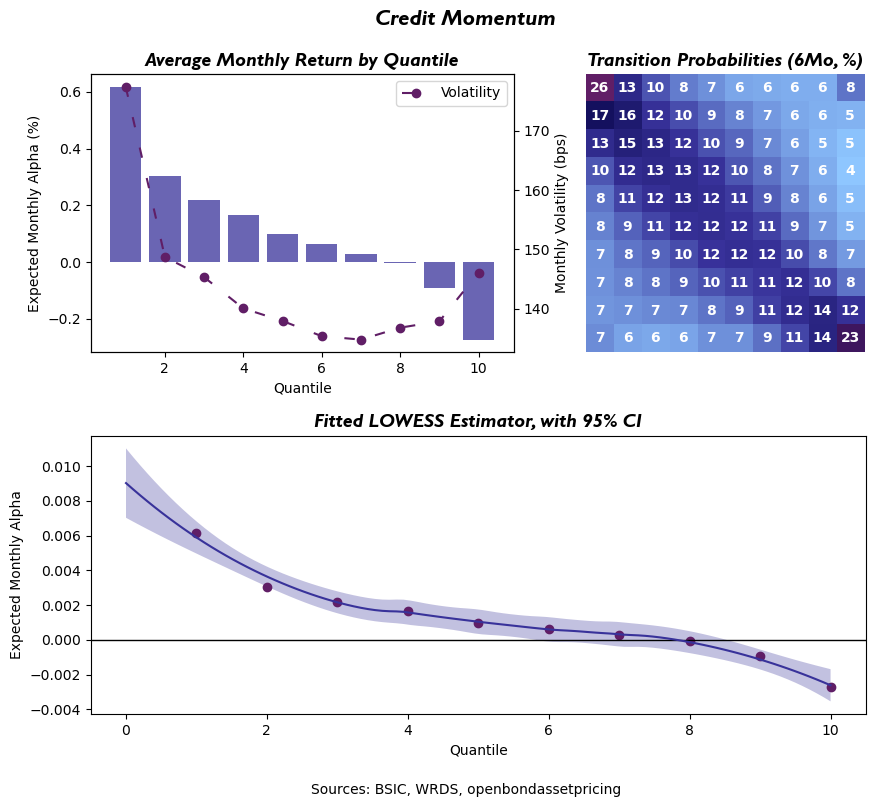

In [44]:
fig = credit_momentum_signal.plot('Credit Momentum', 6)

In [ ]:
export_figure(fig, '../../exports/momentum_factor.svg')

In [45]:
credit_momentum_signal.fit_alpha_estimates()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…

In [46]:
# substitute teh bond_data dataframe to include Credit Momentum data
bond_data = credit_momentum_signal.df

bond_data.select('credit_momentum_signal_value')

credit_momentum_signal_value
f64
null
null
null
null
null
…
1.084302
1.084302
null


## Value Signal (ESP)

We use **Excess Spread to Peers** as a Value Signal in our strategy. For a detailed explanation of ESP, refer to the article.

In [47]:
oas_bucket_means = bond_data.group_by(['date', 'bucket']).agg(pl.col('oas').drop_nans().mean().alias('ESP_bucket_mean_oas'))

In [48]:
oas_bucket_means

date,bucket,ESP_bucket_mean_oas
date,str,f64
2004-04-30,"""5_A_longdur""",0.008691
2016-02-29,"""3_A_longdur""",0.016259
2013-03-31,"""1_A_longdur""",0.012194
2016-01-31,"""3_A_shortdur""",0.010053
2014-06-30,"""2_A_longdur""",0.009365
…,…,…
2016-11-30,"""4_B_shortdur""",0.017456
2012-05-31,"""5_A_longdur""",0.014804
2014-03-31,"""4_B_longdur""",0.017624


In [49]:
bond_data = bond_data.join(oas_bucket_means, on=['date', 'bucket'], how='left')

In [50]:
bond_data = bond_data.with_columns( 
    ESP = pl.col('oas') - pl.col('ESP_bucket_mean_oas'))

In [51]:
bond_data.select('de_ratio', 'intcov_ratio', 'debt_ebitda').null_count()

de_ratio,intcov_ratio,debt_ebitda
u32,u32,u32
157271,197245,158968


In [52]:
bond_data.head(3)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null,0.006591,0.000514


In [58]:
# we substitute the NaN values with None, to make it consistent for filtering using polars 
# (polars treats Nulls and NaNs differently, and this created problems further down the analysis) 
bond_data = bond_data.with_columns(
    ESP=pl.col('ESP').fill_nan(None)
)

In [59]:
bond_data.select('ESP', 'debt_ebitda', 'de_ratio', 'intcov_ratio').dtypes

[Float64, Float64, Float64, Float64]

In [60]:
bond_data.select('ESP').null_count()

ESP
u32
67025


In [61]:
# as explained in the article, we adjust the ESP for fundamentals by doing a rolling OLS
bond_data_with_residuals = bond_data.with_columns(
    esp_residual = pl
        .col('ESP')
        .least_squares
        .ols(pl.col("debt_ebitda"), pl.col("intcov_ratio"), pl.col("de_ratio"), add_intercept=True, mode="residuals", null_policy='drop', solve_method='svd')
        .over(['date', 'bucket'])
)

In [62]:
bond_data = bond_data_with_residuals

Now, we can create the value signal using ESP

In [63]:
value_signal = Signal(bond_data, 'esp_residual', 10, 'esp_signal_value')

In [64]:
# used for the instagram post
def plot_esp_instagram():
    alpha_estimates, spline = value_signal.compute_expected_alpha()
    quantile_col = 'esp_residual_quantile'
    
    fig, barchart_ax = plt.subplots()
    apply_bsic_style(fig)
    barchart_ax.bar(x=alpha_estimates[quantile_col], height=alpha_estimates['avg_monthly_return'] * 1e2, alpha=0.75)
    volatilities_ax = barchart_ax.twinx()
    volatilities_ax.set_ylabel('Monthly Volatility (bps)')
    volatilities_ax.plot(alpha_estimates[quantile_col], alpha_estimates['monthly_stdev'] * 1e4, label='Volatility', color=bsic_constants.BSIC_COLORS[2], linestyle=(0,(5,10)), marker='o')
    volatilities_ax.legend()
    
    barchart_ax.set_title('Average Monthly Return by Quantile', **bsic_constants.TITLE_STYLE)
    barchart_ax.set_xlabel('Quantile')
    barchart_ax.set_ylabel('Expected Monthly Alpha (%)')
    title = 'Excess Spread over Peers (ESP) - Quantile Plot'
    subt = 'Monthly Residual Returns and Volatility for ESP Factor, computed as deviation from average OAS, adjusted for fundamentals of the company. '
    add_title_subtitle(fig, title, subt, subtitle_bottom_margin=-190, title_bottom_margin=-160)
    
    fig.savefig('ESP_factor.png', dpi=1200, transparent=True, bbox_inches='tight')

# plot_esp_instagram()

In [65]:
def plot_esp_instagram_2():
    alpha_estimates, spline = value_signal.compute_expected_alpha()
    quantile_col = 'esp_residual_quantile'
    
    fig, barchart_ax = plt.subplots()
    apply_bsic_style(fig)
    barchart_ax.bar(x=alpha_estimates[quantile_col], height=alpha_estimates['avg_monthly_return'] * 1e2, alpha=0.75)
    volatilities_ax = barchart_ax.twinx()
    volatilities_ax.set_ylabel('Monthly Volatility (bps)')
    volatilities_ax.plot(alpha_estimates[quantile_col], alpha_estimates['monthly_stdev'] * 1e4, label='Volatility', color=bsic_constants.BSIC_COLORS[2], linestyle=(0,(5,10)), marker='o')
    volatilities_ax.legend()
    
    barchart_ax.set_title('Average Monthly Return by Quantile', **bsic_constants.TITLE_STYLE)
    barchart_ax.set_xlabel('Quantile')
    barchart_ax.set_ylabel('Expected Monthly Alpha (%)')
    title = 'Excess Spread over Peers (ESP) - Quantile Plot'
    subt = 'Monthly Residual Returns and Volatility for ESP Factor, computed as deviation from average OAS, adjusted for fundamentals of the company. '
    add_title_subtitle(fig, title, subt, subtitle_bottom_margin=-190, title_bottom_margin=-160)
    
    fig.savefig('ESP_factor.png', dpi=1200, transparent=True, bbox_inches='tight')

# plot_esp_instagram_2()

computing... 1000/4829 2000/4829 3000/4829 4000/4829 ... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


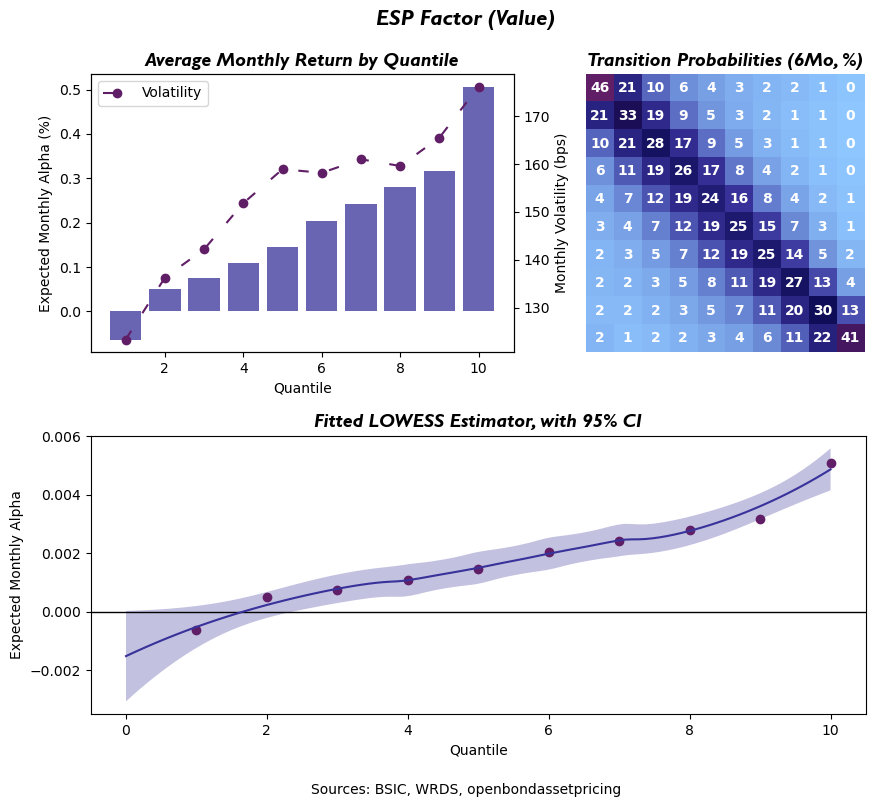

In [66]:
fig = value_signal.plot('ESP Factor (Value)', 6)

In [ ]:
export_figure(fig, '../../exports/value_factor.svg')

In [67]:
value_signal.fit_alpha_estimates()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,2017-05-02,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,2017-05-02,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939,null,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,2017-05-02,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null,0.006591,0.000514,null,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,2017-05-02,null,null,null,null,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null,null,0.006529,0.000918,null,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,2017-05-02,null,null,null,null,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null,null,0.005614,0.001135,null,null,null,null


In [86]:
bond_data = value_signal.df

bond_data.filter(pl.col('esp_signal_value').is_not_null()).select('esp_signal_value').unique()

esp_signal_value
f64
0.576716
1.936683
-0.23988
0.366475
0.073136
-0.703235
1.121369
-1.060179
-0.513434


## Equity Momentum in Credit

In [71]:
def equity_momentum(df: pl.DataFrame, period: str, min_periods: int, n_months: int):
    eq_momentum_returns = df.sort(['cusip', 'date']).rolling('date', group_by='cusip', period=period).agg(
        pl.when(pl.col('equity_month_return').len() > min_periods).then(pl.col('equity_month_return').add(1).product().sub(1)).otherwise(np.nan).alias(f'eq_mom_{n_months}mo'),
        )
    return eq_momentum_returns

eq_mom_6mo = equity_momentum(bond_data, '5mo20d', 5, 6)
eq_mom_12mo = equity_momentum(bond_data, '11mo20d', 9, 12)

bond_data = bond_data.join(
    eq_mom_6mo,
    how='left',
    on=['cusip', 'date'],
).join(
    eq_mom_12mo,
    how='left',
    on=['cusip', 'date'],
)

In [72]:
bond_data.head(2)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN


We opt for the 12mo signal, for the same reasons for which we chose the 12mo credit momentum signal

In [74]:
equity_momentum_signal = Signal(bond_data, 'eq_mom_12mo', 10, 'equity_momentum_signal_value')

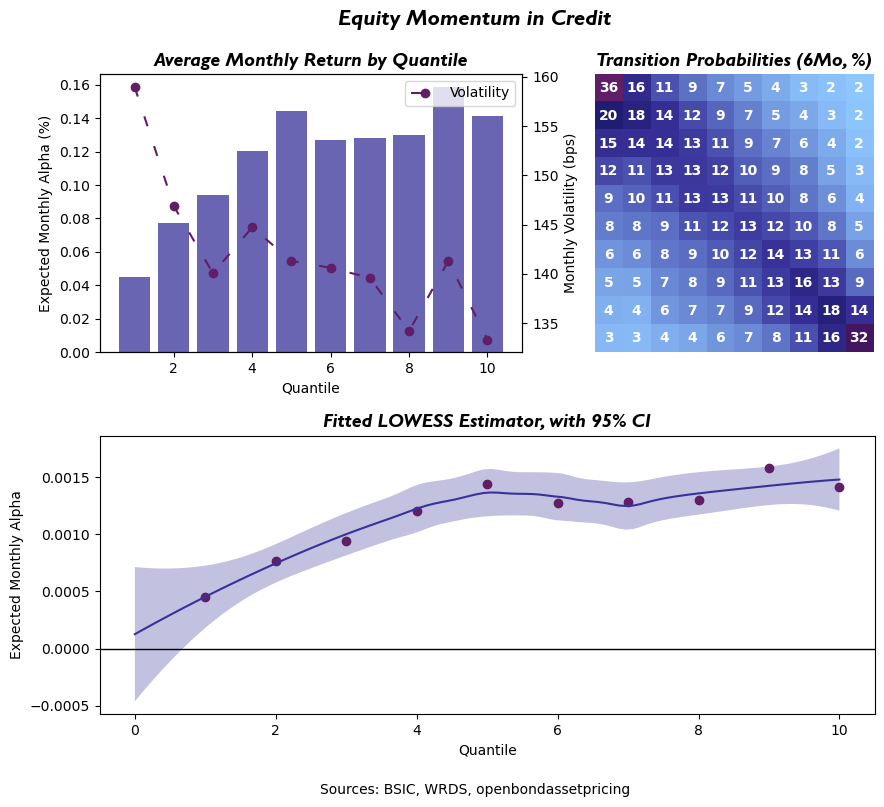

In [76]:
fig = equity_momentum_signal.plot('Equity Momentum in Credit', 6)

In [ ]:
export_figure(fig, '../../exports/equity_momentum_factor.svg')

In [77]:
equity_momentum_signal.fit_alpha_estimates()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_12mo_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null,0.006591,0.000514,null,null,null,null,NaN,NaN,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null,null,0.006529,0.000918,null,null,null,null,NaN,NaN,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null,null,0.005614,0.001135,null,null,null,null,NaN,NaN,null,null,null
…,

In [78]:
bond_data = equity_momentum_signal.df

bond_data.select('equity_momentum_signal_value')

equity_momentum_signal_value
f64
null
null
null
null
null
…
0.854494
1.020644
0.854494


## Factors Correlation

In [79]:
import seaborn as sns
import pandas as pd 

In [80]:
factors = bond_data.select('date', 'cusip', 'credit_momentum_signal_value', 'esp_signal_value', 'carry_signal_value', 'equity_momentum_signal_value')
factors = factors.to_pandas()
factors: pd.DataFrame

factors = factors.rename(columns={
    'credit_momentum_signal_value': 'Credit Momentum',
    'esp_signal_value': 'ESP Factor',
    'carry_signal_value': 'Carry Factor',
    'equity_momentum_signal_value': 'Equity Momentum'
})

In [81]:
correlations = factors.corr(numeric_only=True)
correlations

,Credit Momentum,ESP Factor,Carry Factor,Equity Momentum
Credit Momentum,1.000000,0.126271,0.122230,-0.135309
ESP Factor,0.126271,1.000000,0.860770,-0.101691
Carry Factor,0.122230,0.860770,1.000000,-0.129161
Equity Momentum,-0.135309,-0.101691,-0.129161,1.000000


In [82]:
def plot_factors_corr():
    bsic_cmap = mcolors.LinearSegmentedColormap.from_list(
        "bsic", ["#8EC6FF", "#38329A", "#0E0B54", "#601E66"]
    )
    plt.rcParams.update({'axes.grid': False})
    fig, ax = plt.subplots(figsize=(10,5))
    
    mask = np.triu(np.ones_like(correlations, dtype=bool))
    heatmap = sns.heatmap(correlations, mask=mask, annot=True, cmap=bsic_cmap, square=True)
    ax.set_title('Factors Correlation')
    
    apply_bsic_style(fig, ax)
    # title = 'Factors Correlations'
    # subtitle = 'test bla bla bla'
    fig.subplots_adjust()
    # add_title_subtitle(fig, title, subtitle)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        right=False,      # ticks along the bottom edge are off
        left=False)
    # ticks along the top edge are off) # labels along the bottom edge are off

    export_figure(fig, '../../exports/factors_correlations')
    
# plot_factors_corr()

## Conclusing 

In [83]:
bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_12mo_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null,0.006591,0.000514,null,null,null,null,NaN,NaN,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null,null,0.006529,0.000918,null,null,null,null,NaN,NaN,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null,null,0.005614,0.001135,null,null,null,null,NaN,NaN,null,null,null


In [84]:
bond_data.null_count() / bond_data.shape[0]

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_12mo_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.157823,0.160343,0.160343,0.157823,0.154488,0.154488,0.157058,0.0,0.005386,0.076994,0.005288,0.0,0.0,0.086276,0.086276,0.0,0.000228,0.088345,0.0,0.061389,0.09454,0.400065,0.058481,0.0,0.0,0.027681,0.027681,0.027681,0.027681,0.027681,0.113375,0.086276,0.027681,0.0,…,0.253899,0.367488,0.083138,0.91892,0.91892,0.0,0.0,0.005292,0.0,0.005292,0.0,0.0,0.005292,0.005292,0.162617,0.086276,0.086276,0.086276,0.01503,0.098118,0.212377,0.124259,0.249524,0.249524,0.249524,0.249524,0.000018,0.086276,0.32008,0.32008,0.32008,0.32008,0.0,0.0,0.124259,0.124259,0.124259


In [ ]:
bond_data.write_parquet('../../data/final_data/data_with_signals_all.pq', compression='zstd', compression_level=10)